<a href="https://colab.research.google.com/github/radanim/TIL/blob/master/06_fbprophet_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이브러리 로드

In [1]:
!pip install -U finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 126 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.8 MB/s 

  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6639007 sha256=9753c63123e2f07f3a9026c456fecc031591e3656d03026f940c783017f6d12a
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.7
    Uninstalling cmdstanpy-1.0.7:
      Successfully uninstalled cmdstanpy-1.0.7
ERROR: pip's dependency resolver does not currently take into account all the

In [3]:
# 데이터 분석을 위한 pandas, 시각화를 위한 matplotlib, 주가 데이터 수집을 위한 FinanceDataReader
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import numpy as np

## 삼성전자 일별시세 불러오기

In [10]:
# 삼성전자 : 005930
df=fdr.DataReader("005930","2021","2022")

In [11]:
# 일별 시세 미리보기
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,0.024691
2021-01-05,81600,83900,81600,83900,35335669,0.010843
2021-01-06,83300,84500,82100,82200,42089013,-0.020262
2021-01-07,82800,84200,82700,82900,32644642,0.008516
2021-01-08,83300,90000,83000,88800,59013307,0.071170


In [15]:
df2 = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df2.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


## 시계열데이터 분석

## fbprophet

In [12]:
from fbprophet import Prophet

In [16]:
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-04,81000,84400,80200,83000,38655276,0.024691
2021-01-05,81600,83900,81600,83900,35335669,0.010843
2021-01-06,83300,84500,82100,82200,42089013,-0.020262
2021-01-07,82800,84200,82700,82900,32644642,0.008516
2021-01-08,83300,90000,83000,88800,59013307,0.071170


In [20]:
# Format data for prophet model using ds and y
# 시간은 ds, 데이터 값은 y로 지정
df_dsy=df['Close'].reset_index()
df_dsy.columns=["ds","y"]
df_dsy.head(2)

,ds,y
0,2021-01-04,83000
1,2021-01-05,83900


In [21]:
# 12월 예측하기
# 1~11 > Train
# 12 > Test
train = df_dsy[df_dsy["ds"].dt.month < 12 ]
test = df_dsy[df_dsy["ds"].dt.month >= 12]
train.shape, test.shape

((226, 2), (22, 2))

In [22]:
display(train.tail(2))
display(test.head(2))

,ds,y
224,2021-11-29,72300
225,2021-11-30,71300


,ds,y
226,2021-12-01,74400
227,2021-12-02,75800


* 참고

- 상한과 하한을 설정시 Prophet(growth='logistic')로 모델설정
- 상한 설정시 df['cap'] = 상한 값
- 하한 설정시 df['floor'] = 하한 값

In [24]:
# Default growth='linear'
# 기본적으로 Prophet은 시계열 데이터의 80% 크기에서 잠재적으로 ChangePoint를 지정
model = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=True)
model.add_country_holidays("KR")
model.add_seasonality(name="weekly",period=5,fourier_order=10)
model.fit(train)

In [26]:
# 미래 dataframe 생성
future=model.make_future_dataframe(periods=30, freq="D", include_history=True)
future.shape


(256, 1)

In [27]:
future.head(2)

,ds
0,2021-01-04
1,2021-01-05


In [28]:
future.tail(2)

,ds
254,2021-12-29
255,2021-12-30


In [32]:
# predict
forecast=model.predict(future)
print(forecast.shape)
forecast.tail()


(256, 82)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Hangeul Day,Alternative holiday of Hangeul Day_lower,Alternative holiday of Hangeul Day_upper,Alternative holiday of Liberation Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
251,2021-12-26,70482.569873,60754.446925,63824.989928,70482.442629,70482.710981,0.0,0.0,0.0,0.0,...,-142.573413,-142.573413,-142.573413,-9166.395290,-9166.395290,-9166.395290,0.0,0.0,0.0,62314.188475
252,2021-12-27,70446.858457,61825.446904,64741.411547,70446.723640,70447.007038,0.0,0.0,0.0,0.0,...,243.999333,243.999333,243.999333,-8528.036547,-8528.036547,-8528.036547,0.0,0.0,0.0,63303.408548
253,2021-12-28,70411.147042,62591.061651,65543.172357,70411.002829,70411.304983,0.0,0.0,0.0,0.0,...,349.340484,349.340484,349.340484,-7811.494934,-7811.494934,-7811.494934,0.0,0.0,0.0,64089.579897
254,2021-12-29,70375.435627,62884.626177,65862.093977,70375.282902,70375.599109,0.0,0.0,0.0,0.0,...,-48.999420,-48.999420,-48.999420,-7027.334295,-7027.334295,-7027.334295,0.0,0.0,0.0,64439.689217
255,2021-12-30,70339.724212,63606.813544,66595.781854,70339.559354,70339.895826,0.0,0.0,0.0,0.0,...,-108.708483,-108.708483,-108.708483,-6187.250980,-6187.250980,-6187.250980,0.0,0.0,0.0,65184.352054


In [33]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']] #yhat

,ds,yhat,yhat_lower,yhat_upper
0,2021-01-04,83226.280561,81615.176157,84692.142636
1,2021-01-05,84185.558467,82672.617359,85700.525048
2,2021-01-06,84601.616749,83114.493250,86191.425381
3,2021-01-07,85305.427511,83775.746049,86731.584610
4,2021-01-08,85966.115491,84453.648514,87527.947639
...,...,...,...,...
251,2021-12-26,62314.188475,60754.446925,63824.989928
252,2021-12-27,63303.408548,61825.446904,64741.411547
253,2021-12-28,64089.579897,62591.061651,65543.172357
254,2021-12-29,64439.689217,62884.626177,65862.093977


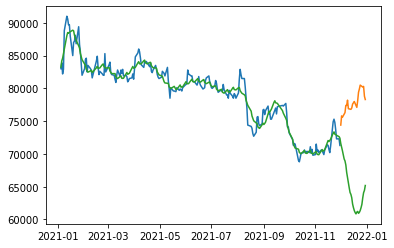

In [35]:
# train['y'], test['y'], forecast['yhat'] plot
plt.plot(train["ds"], train["y"])
plt.plot(test["ds"], test["y"])
plt.plot(forecast["ds"],forecast["yhat"])

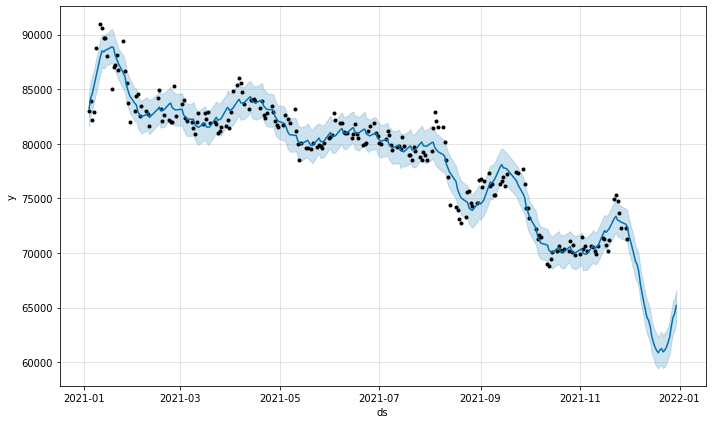

In [36]:
# forecast 시각화
# 검은 점은 실측치, 하늘색 선은 예측치, 연한 하늘색 영역은 신뢰 구간(디폴트는 80%)
model.plot(forecast)
plt.show()

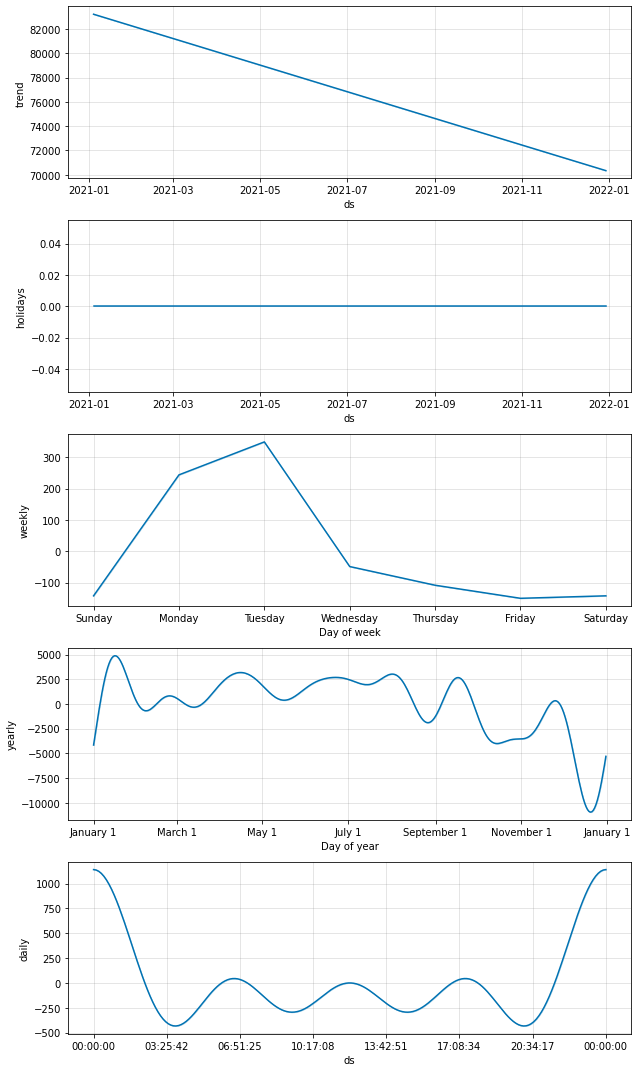

In [37]:
# forecast component 시각화(Trend, Weakly, Yearly)
model.plot_components(forecast)
plt.show()

### Prophet에서 조정이 가능한 파라미터

- 데이터의 상한 하한의 설정
- 변동 포인트의 설정
- 계절성의 조정
- 특별 이벤트의 추가
- 신뢰 구간의 조정

In [38]:
df["Close"].describe()

count      248.000000
mean     79155.645161
std       4826.400112
min      68800.000000
25%      76250.000000
50%      80100.000000
75%      82225.000000
max      91000.000000
Name: Close, dtype: float64

In [41]:
cap = 80000
floor = 50000

In [42]:
# 데이터의 상한 하한의 설정
# fit
model = Prophet(growth = 'logistic')
train['cap'] = cap
train['floor'] = floor
model.fit(train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [47]:
future = model.make_future_dataframe(periods=30, freq="D", include_history=True)
# future
future['cap'] = cap
future['floor'] = floor
future.shape

(256, 3)

In [48]:
future.tail(2)

,ds,cap,floor
254,2021-12-29,80000,50000
255,2021-12-30,80000,50000


In [54]:
# predict
forecast=model.predict(future)
# forecast


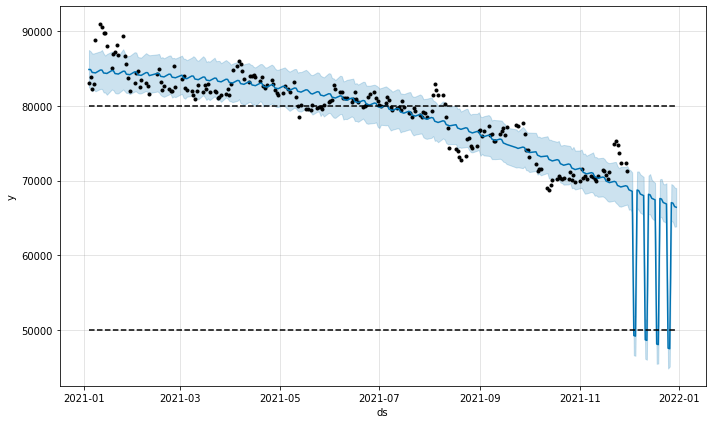

In [55]:
# model.plot
model.plot(forecast)
plt.show()

In [56]:
# 변동 포인트의 설정
# 빨간 실선은 Trend를 의미(변경점 자동 감지)
# Prophet, fit, predict
# changepoint_prior_scale=0.5, yearly_seasonality=True, daily_seasonality=True
model=Prophet(changepoint_prior_scale=0.5, yearly_seasonality=True, daily_seasonality=True)

In [57]:
# fit, predict
model.fit(train)
forecast=model.predict(future)

In [59]:
forecast.tail(2)

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
254,2021-12-29,58082.176449,80000,55590.809709,63612.740866,54494.003723,62317.211099,1275.503278,1275.503278,1275.503278,...,-613.860198,-613.860198,-613.860198,12007.638836,12007.638836,12007.638836,0.0,0.0,0.0,59357.679727
255,2021-12-30,57712.302354,80000,55816.969328,64391.129895,53918.181248,62174.255890,2066.100587,2066.100587,2066.100587,...,-663.395396,-663.395396,-663.395396,12847.771342,12847.771342,12847.771342,0.0,0.0,0.0,59778.402941


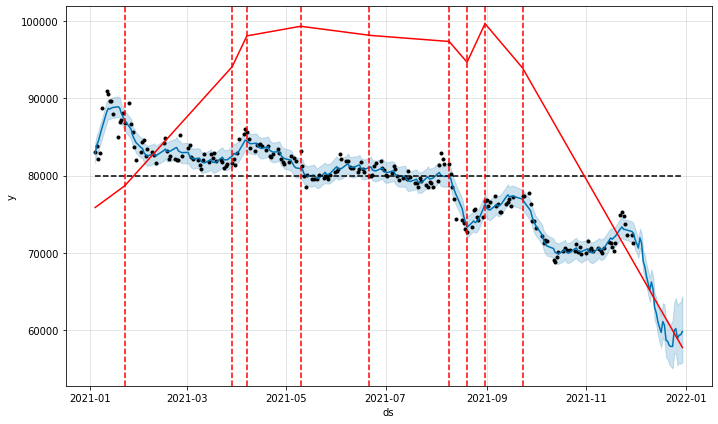

In [63]:
from fbprophet.plot import add_changepoints_to_plot
# plot, add_changepoints_to_plot
fig=model.plot(forecast)
a=add_changepoints_to_plot(fig.gca(),model,forecast)

In [65]:
# 특별 이벤트의 추가
# 내장된 나라별 공휴일 설정
# yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True
# add_country_holidays(country_name='KR')
model=Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True)
model.add_country_holidays(country_name='KR')
model.fit(train)

In [66]:
# model.train_holiday_names
model.train_holiday_names

0                                     New Year's Day
1          The day preceding of Lunar New Year's Day
2                               Lunar New Year's Day
3             The second day of Lunar New Year's Day
4                          Independence Movement Day
5                             Birthday of the Buddha
6                                     Children's Day
7                                         Labour Day
8                                       Memorial Day
9                                     Liberation Day
10             Alternative holiday of Liberation Day
11                      The day preceding of Chuseok
12                                           Chuseok
13                         The second day of Chuseok
14                           National Foundation Day
15    Alternative holiday of National Foundation Day
16                                       Hangeul Day
17                Alternative holiday of Hangeul Day
18                                     Christm

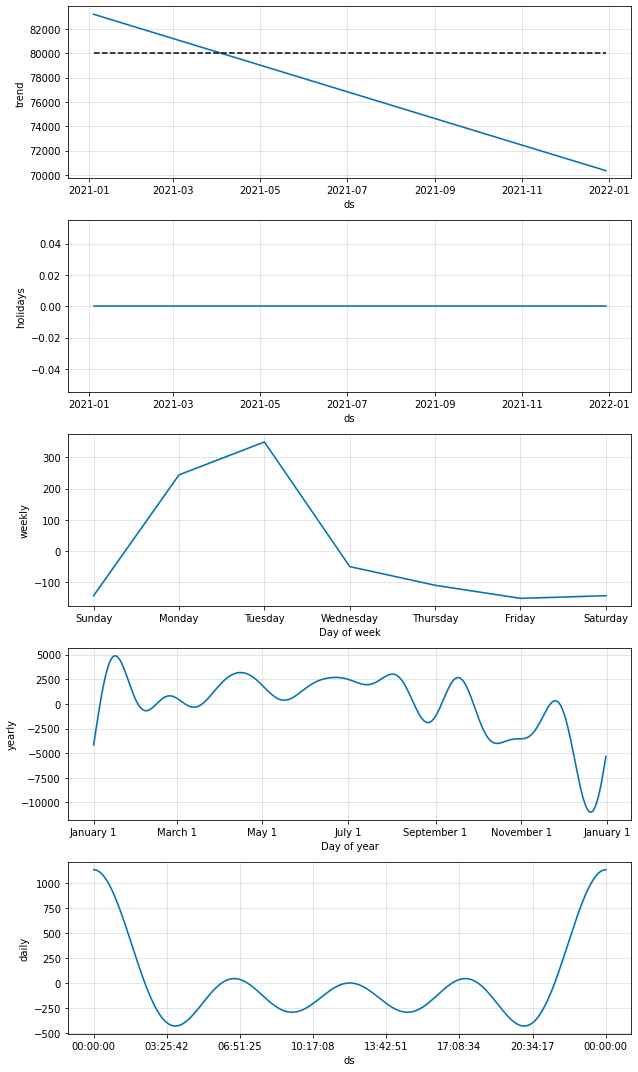

In [67]:
# predict, plot_components
forecast = model.predict(future)
_=model.plot_components(forecast)

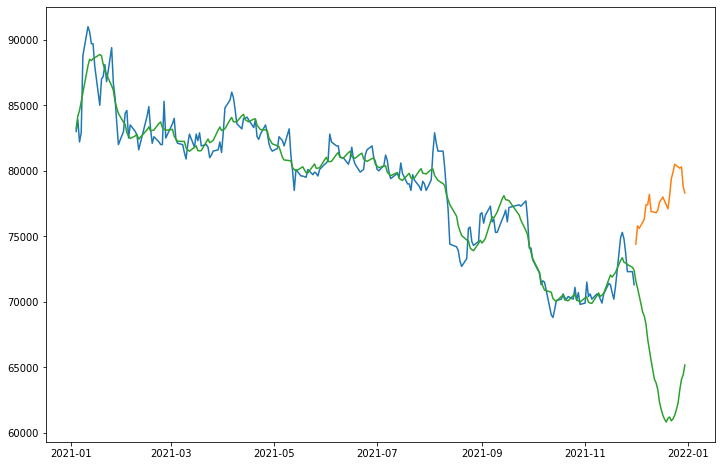

In [68]:
# train['y'], test['y'], forecast['yhat'] plot
plt.figure(figsize=(12,8))
plt.plot(train["ds"],train["y"])
plt.plot(test["ds"], test["y"])
plt.plot(forecast["ds"],forecast["yhat"])

In [69]:
df_predict=forecast.loc[forecast["ds"]>="2021-12-01",["ds","yhat"]]

In [72]:
# rmse
np.sqrt(((test["y"]-df_predict["yhat"])**2).mean())

13576.00465453367

## 한계점

In [73]:
# 삼성전자 : 005930
df_long = fdr.DataReader("005930","2000")


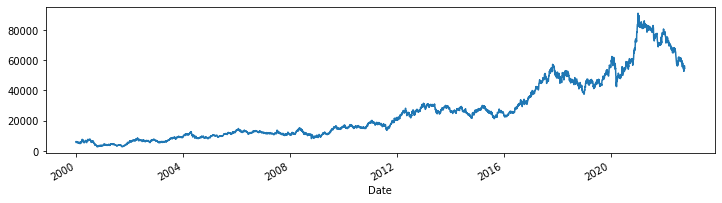

In [74]:
df_long["Close"].plot(figsize=(12,3))

In [75]:
# Format data for prophet model using ds and y
# 시간은 ds, 데이터 값은 y로 지정
df_pro=df_long["Close"].reset_index()
df_pro.columns=["ds","y"]
df_pro.head(2)

,ds,y
0,2000-01-04,6110
1,2000-01-05,5580


In [77]:
# 2022년 예측하기
# train > 2021년까지
# test > 2022년까지 

train=df_pro[df_pro["ds"].dt.year<2022]
test=df_pro[df_pro["ds"].dt.year>=2022]
train.shape, test.shape

((5432, 2), (189, 2))

In [78]:
# Default growth='linear'
# 기본적으로 Prophet은 시계열 데이터의 80% 크기에서 잠재적으로 ChangePoint를 지정
# yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True
# add_country_holidays(country_name='KR')
# add_seasonality(name='weekly', period=5, fourier_order=10, prior_scale=0.1)
# fit
model=Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.add_country_holidays(country_name="KR")
model.add_seasonality(name='weekly',period=5,fourier_order=10,prior_scale=0.1)
model.fit(train)


In [80]:
# 미래 dataframe 생성
future = model.make_future_dataframe(periods=221,freq="D")
future.tail(2)

,ds
5651,2022-08-07
5652,2022-08-08


In [81]:
# predict
forecast=model.predict(future)

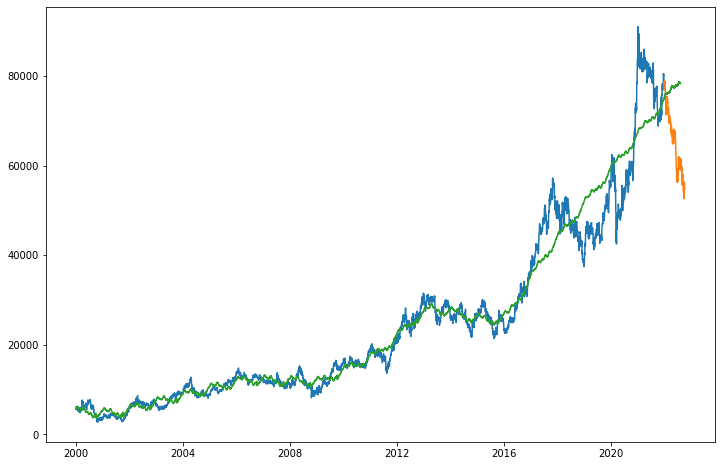

In [84]:
# train['y'], test['y'], forecast['yhat'] plot
plt.figure(figsize=(12,8))
plt.plot(train["ds"],train["y"])
plt.plot(test["ds"],test["y"])
plt.plot(forecast["ds"],forecast["yhat"])